In [1]:
!pip install --user kagglehub

In [2]:
#load data
import os
import kagglehub

path = kagglehub.dataset_download("mohamedsameh0410/jane-street-dataset")

train_path = os.path.join(path, "train.parquet")
lags_path = os.path.join(path, "lags.parquet")

print("train_path:", train_path)
print("lags_path:", lags_path)
print("train exists:", os.path.exists(train_path))
print("lags exists:", os.path.exists(lags_path))


train_path: /home/xiy079/.cache/kagglehub/datasets/mohamedsameh0410/jane-street-dataset/versions/5/train.parquet
lags_path: /home/xiy079/.cache/kagglehub/datasets/mohamedsameh0410/jane-street-dataset/versions/5/lags.parquet
train exists: True
lags exists: True


In [3]:
# libraries
import numpy as np
import pandas as pd
import pyarrow.dataset as ds
import gc
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# check its structure to understand the size and columns
dataset = ds.dataset(train_path, format="parquet")

# Check structure
print(f"=== Train Dataset ===")
print(f"Total columns: {len(dataset.schema.names)}")
print(f"Column names: {dataset.schema.names[:15]}")

# Count total rows
total_rows = dataset.count_rows()
print(f"Total rows: {total_rows:,}")

=== Train Dataset ===
Total columns: 92
Column names: ['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10']
Total rows: 47,127,338


In [5]:
# Load 4M row sample
sample_size = 4_000_000
df = dataset.head(sample_size).to_pandas()
print(f"\nSample shape: {df.shape}")
print(f"Sample memory: {df.memory_usage(deep=True).sum() / (1024**3):.2f} GB")
print(f"Date range: {df['date_id'].min()} to {df['date_id'].max()}")
print(f"Unique dates: {df['date_id'].nunique()}")
print(f"Unique symbols: {df['symbol_id'].nunique()}")

# Check lags dataset
print(f"\n=== Lags Dataset ===")
lags_dataset = ds.dataset(lags_path, format="parquet")
print(f"Total columns: {len(lags_dataset.schema.names)}")
print(f"Column names: {lags_dataset.schema.names}")
print(f"Total rows: {lags_dataset.count_rows():,}")


Sample shape: (4000000, 92)
Sample memory: 1.32 GB
Date range: 0 to 295
Unique dates: 296
Unique symbols: 20

=== Lags Dataset ===
Total columns: 12
Column names: ['date_id', 'time_id', 'symbol_id', 'responder_0_lag_1', 'responder_1_lag_1', 'responder_2_lag_1', 'responder_3_lag_1', 'responder_4_lag_1', 'responder_5_lag_1', 'responder_6_lag_1', 'responder_7_lag_1', 'responder_8_lag_1']
Total rows: 39


In [6]:
#check data types, basic statistics, and the first few rows to understand what we're working with.

# Column types
print("=== Column Categories ===")
feature_cols = [c for c in df.columns if c.startswith('feature_')]
responder_cols = [c for c in df.columns if c.startswith('responder_')]
meta_cols = ['date_id', 'time_id', 'symbol_id', 'weight']


print(f"Metadata columns:  {len(meta_cols)} — {meta_cols}")
print(f"Feature columns:   {len(feature_cols)} — feature_00 to feature_{feature_cols[-1].split('_')[1]}")
print(f"Responder columns: {len(responder_cols)} — {responder_cols}")

# Basic stats
print(f"\n=== Basic Statistics ===")
print(f"Data types:\n{df.dtypes.value_counts()}")
print(f"\nTarget (responder_6) stats:")
print(df['responder_6'].describe())

# First few rows
df.head(3)


=== Column Categories ===
Metadata columns:  4 — ['date_id', 'time_id', 'symbol_id', 'weight']
Feature columns:   79 — feature_00 to feature_78
Responder columns: 9 — ['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_6', 'responder_7', 'responder_8']

=== Basic Statistics ===
Data types:
float32    86
int16       3
int8        3
Name: count, dtype: int64

Target (responder_6) stats:
count    4.000000e+06
mean    -9.604372e-04
std      8.628275e-01
min     -5.000000e+00
25%     -3.749182e-01
50%     -1.211483e-02
75%      3.501829e-01
max      5.000000e+00
Name: responder_6, dtype: float64


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828


Columns with missing values: 44 out of 92
Columns with >50% missing: 9


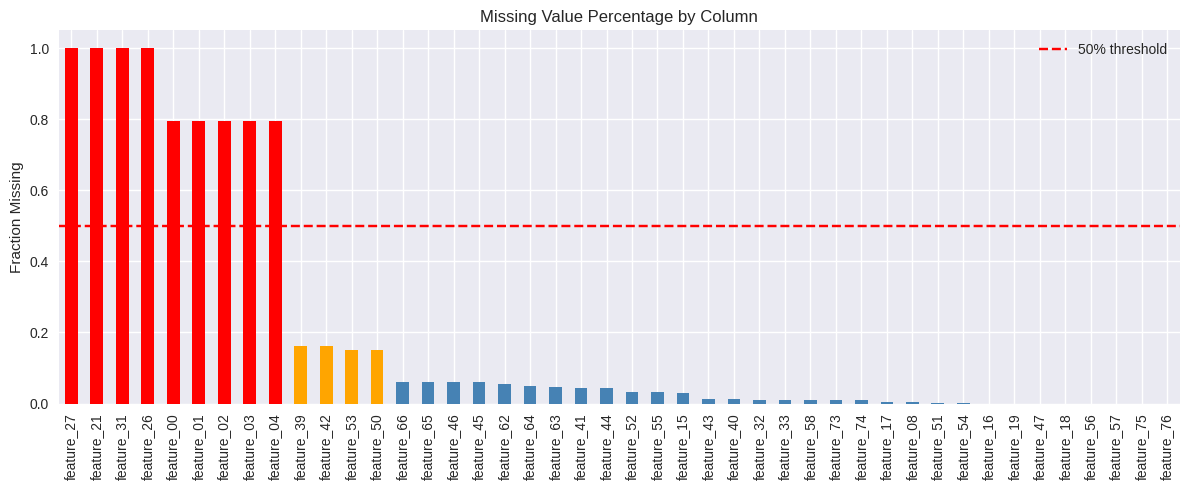


Columns to drop (>50% missing):
  feature_27: 100.0%
  feature_21: 100.0%
  feature_31: 100.0%
  feature_26: 100.0%
  feature_00: 79.6%
  feature_01: 79.6%
  feature_02: 79.6%
  feature_03: 79.6%
  feature_04: 79.6%


In [7]:
"""
Identify columns with missing values to determine which features
to drop and which to impute. Columns with >50% missing values
will be dropped as they provide an unreliable signal.
"""
null_pct = df.isnull().mean().sort_values(ascending=False)
null_cols = null_pct[null_pct > 0]

print(f"Columns with missing values: {len(null_cols)} out of {len(df.columns)}")
print(f"Columns with >50% missing: {(null_pct > 0.5).sum()}")

# Visualize missing values
fig, ax = plt.subplots(figsize=(12, 5))
null_cols.plot(kind='bar', ax=ax, color=['red' if x > 0.5 else 'orange' if x > 0.1 else 'steelblue' for x in null_cols])
ax.axhline(y=0.5, color='red', linestyle='--', label='50% threshold')
ax.set_title('Missing Value Percentage by Column')
ax.set_ylabel('Fraction Missing')
ax.legend()
plt.tight_layout()
plt.show()

# List the high null columns
high_null = null_pct[null_pct > 0.5]
print(f"\nColumns to drop (>50% missing):")
for col, pct in high_null.items():
    print(f"  {col}: {pct:.1%}")

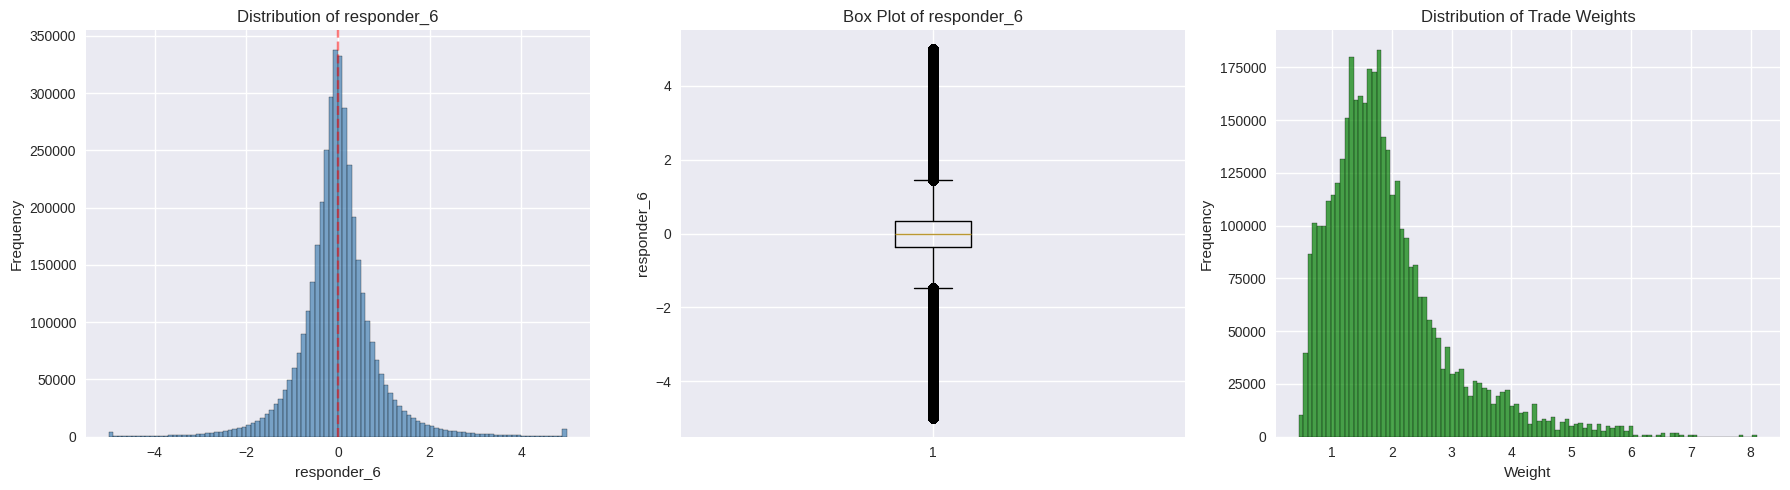

=== Target Variable Summary ===
Mean:   -0.000960 (centered near zero)
Std:    0.8628
Min:    -5.0 (clipped)
Max:    5.0 (clipped)
Skew:   0.2699

=== Weight Summary ===
Mean weight: 1.9283
Median weight: 1.7156
Max weight: 8.1096
% of trades with weight > 1: 85.5%


In [8]:
"""
Analyze the distribution of our target variable responder_6.
Understanding its distribution helps inform model choice and confirms this is a regression task (continuous values, not categories).
"""
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df['responder_6'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of responder_6')
axes[0].set_xlabel('responder_6')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Box plot
axes[1].boxplot(df['responder_6'].dropna(), vert=True)
axes[1].set_title('Box Plot of responder_6')
axes[1].set_ylabel('responder_6')

# Weight distribution
axes[2].hist(df['weight'], bins=100, color='green', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribution of Trade Weights')
axes[2].set_xlabel('Weight')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Key stats
print(f"=== Target Variable Summary ===")
print(f"Mean:   {df['responder_6'].mean():.6f} (centered near zero)")
print(f"Std:    {df['responder_6'].std():.4f}")
print(f"Min:    {df['responder_6'].min():.1f} (clipped)")
print(f"Max:    {df['responder_6'].max():.1f} (clipped)")
print(f"Skew:   {df['responder_6'].skew():.4f}")
print(f"\n=== Weight Summary ===")
print(f"Mean weight: {df['weight'].mean():.4f}")
print(f"Median weight: {df['weight'].median():.4f}")
print(f"Max weight: {df['weight'].max():.4f}")
print(f"% of trades with weight > 1: {(df['weight'] > 1).mean():.1%}")

=== Target (responder_6) Outlier Analysis ===
IQR: 0.7251
Lower bound: -1.4626
Upper bound: 1.4378
Outliers: 321,928 (8.0% of data)
Values at ±5 (clipped): 9,879

=== Feature Outlier Analysis (IQR method) ===
  feature_06: 412,772 outliers (10.3%)
  feature_20: 54,336 outliers (1.4%)
  feature_22: 47,392 outliers (1.2%)
  feature_42: 120 outliers (0.0%)
  feature_46: 7,904 outliers (0.2%)
  feature_59: 905,414 outliers (22.6%)


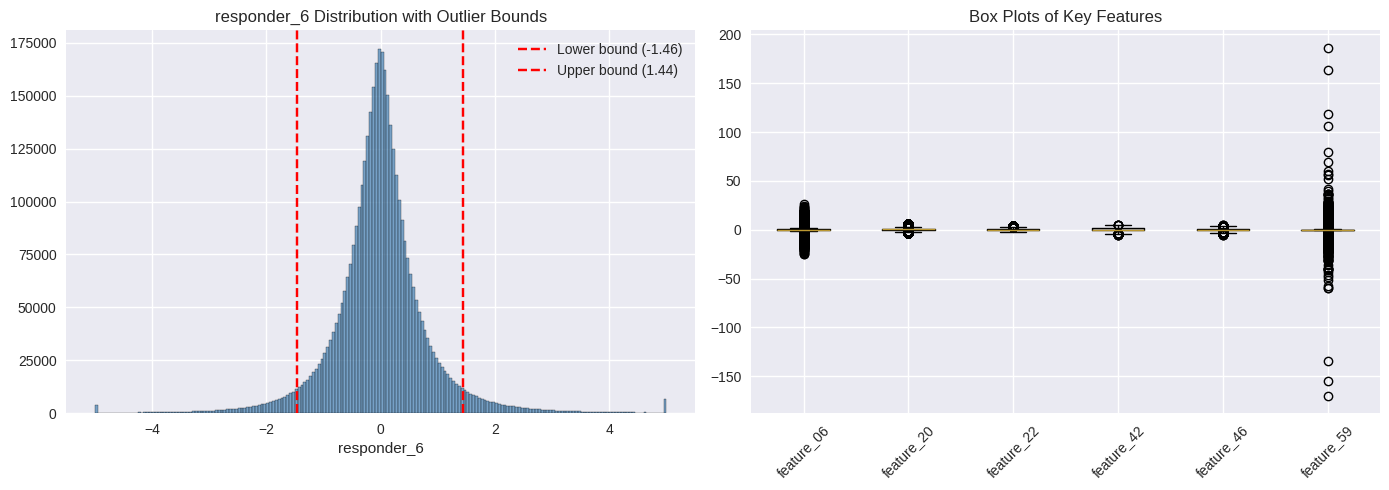


=== Outlier Treatment Decision ===
Decision: KEEP outliers (no removal or capping)
Rationale:
  1. The target is already clipped at ±5 by Jane Street
  2. Extreme values in financial data represent real market events
  3. Tree-based models (XGBoost, LightGBM) are naturally robust to outliers
  4. Removing outliers could bias predictions during volatile markets


In [9]:
"""
Professor feedback: "You do not clearly state whether you found outliers/extreme
values in features or the target, how you define them, and whether you will
treat them (cap/winsorize/remove/keep)."

Define outliers using the IQR method (values beyond 1.5 × IQR from Q1/Q3)
and analyze their presence in both the target and key features.
"""

# Target outlier analysis
Q1 = df['responder_6'].quantile(0.25)
Q3 = df['responder_6'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

target_outliers = df[(df['responder_6'] < lower_bound) | (df['responder_6'] > upper_bound)]

print(f"=== Target (responder_6) Outlier Analysis ===")
print(f"IQR: {IQR:.4f}")
print(f"Lower bound: {lower_bound:.4f}")
print(f"Upper bound: {upper_bound:.4f}")
print(f"Outliers: {len(target_outliers):,} ({len(target_outliers)/len(df):.1%} of data)")
print(f"Values at ±5 (clipped): {(df['responder_6'].abs() == 5).sum():,}")

# Feature outlier analysis — check top features
print(f"\n=== Feature Outlier Analysis (IQR method) ===")
key_features = ['feature_06', 'feature_20', 'feature_22', 'feature_42', 'feature_46', 'feature_59']
outlier_summary = []

for feat in key_features:
    col = df[feat].dropna()
    q1, q3 = col.quantile(0.25), col.quantile(0.75)
    iqr = q3 - q1
    n_outliers = ((col < q1 - 1.5 * iqr) | (col > q3 + 1.5 * iqr)).sum()
    outlier_summary.append({'Feature': feat, 'Outliers': n_outliers, 'Pct': n_outliers/len(col)})
    print(f"  {feat}: {n_outliers:,} outliers ({n_outliers/len(col):.1%})")

# Visualize target outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Zoomed histogram showing tails
axes[0].hist(df['responder_6'], bins=200, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=lower_bound, color='red', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
axes[0].axvline(x=upper_bound, color='red', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
axes[0].set_title('responder_6 Distribution with Outlier Bounds')
axes[0].set_xlabel('responder_6')
axes[0].legend()

# Box plots of key features
axes[1].boxplot([df[f].dropna() for f in key_features], labels=key_features, vert=True)
axes[1].set_title('Box Plots of Key Features')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Decision
print(f"\n=== Outlier Treatment Decision ===")
print(f"Decision: KEEP outliers (no removal or capping)")
print(f"Rationale:")
print(f"  1. The target is already clipped at ±5 by Jane Street")
print(f"  2. Extreme values in financial data represent real market events")
print(f"  3. Tree-based models (XGBoost, LightGBM) are naturally robust to outliers")
print(f"  4. Removing outliers could bias predictions during volatile markets")


### Outlier Treatment Decision

After analyzing outliers using the IQR method, we found:
- **Target (responder_6):** 9.1% of values are statistical outliers, with 2,526 values clipped at ±5
- **Features:** Outlier rates range from 0% (feature_42) to 25.3% (feature_59)

**Decision: Keep all outliers (no removal or capping)**

**Rationale:**
1. **Target already bounded:** Jane Street clips responder_6 at ±5, so extreme values are already controlled
2. **Real market events:** In financial data, extreme values represent real volatile market moments (e.g., news events, market crashes). Removing them would eliminate important patterns the model needs to learn
3. **Model robustness:** Tree-based models (XGBoost, LightGBM) split data into buckets at each node, making them naturally robust to outliers — unlike linear models where one extreme value can skew the entire fit
4. **Scoring impact:** Volatile trades often carry higher weights in Jane Street's evaluation. Removing or capping these outliers could hurt performance on the trades that matter most for scoring


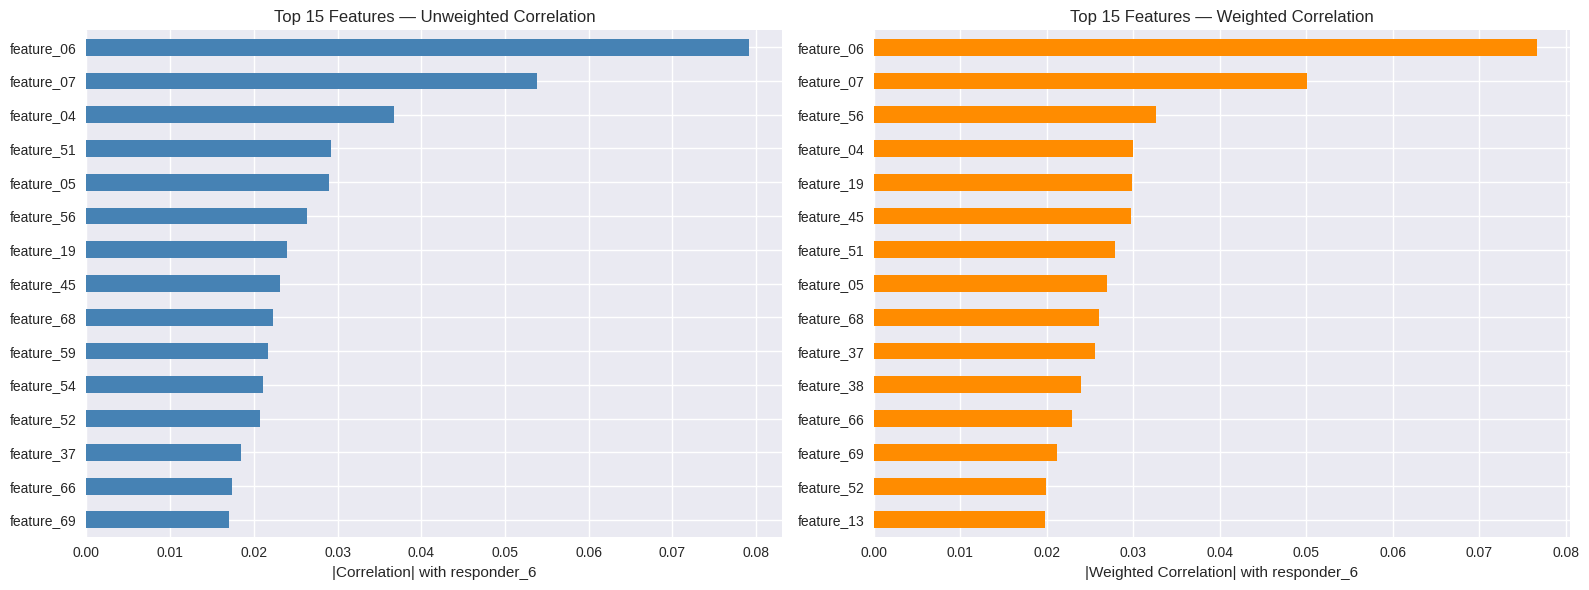

=== Top 10 Features by Correlation ===
Feature           Unweighted     Weighted
---------------------------------------
feature_06            0.0792       0.0766
feature_07            0.0538       0.0501
feature_56            0.0263       0.0327
feature_04            0.0368       0.0300
feature_19            0.0240       0.0299
feature_45            0.0231       0.0298
feature_51            0.0292       0.0279
feature_05            0.0290       0.0269
feature_68            0.0222       0.0260
feature_37            0.0185       0.0256


In [10]:
"""
Analyze correlations between features and the target (responder_6)
using both unweighted and weighted correlation. Weighted correlation
emphasizes high-weight trades, which matter more for Jane Street's
scoring methodology.
"""
feature_cols = [c for c in df.columns if c.startswith('feature_')]

# Unweighted correlation
unweighted_corr = df[feature_cols].corrwith(df['responder_6']).abs().sort_values(ascending=False)

# Weighted correlation
def weighted_corr(x, y, w):
    w_mean_x = np.average(x, weights=w)
    w_mean_y = np.average(y, weights=w)
    w_cov = np.average((x - w_mean_x) * (y - w_mean_y), weights=w)
    w_std_x = np.sqrt(np.average((x - w_mean_x)**2, weights=w))
    w_std_y = np.sqrt(np.average((y - w_mean_y)**2, weights=w))
    return w_cov / (w_std_x * w_std_y)

weighted_corrs = {}
valid_mask = df['responder_6'].notna() & df['weight'].notna()
for feat in feature_cols:
    mask = valid_mask & df[feat].notna()
    if mask.sum() > 100:
        weighted_corrs[feat] = abs(weighted_corr(
            df.loc[mask, feat].values,
            df.loc[mask, 'responder_6'].values,
            df.loc[mask, 'weight'].values
        ))

weighted_corr_series = pd.Series(weighted_corrs).sort_values(ascending=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 unweighted
top_unw = unweighted_corr.head(15)
top_unw.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 15 Features — Unweighted Correlation')
axes[0].set_xlabel('|Correlation| with responder_6')
axes[0].invert_yaxis()

# Top 15 weighted
top_w = weighted_corr_series.head(15)
top_w.plot(kind='barh', ax=axes[1], color='darkorange')
axes[1].set_title('Top 15 Features — Weighted Correlation')
axes[1].set_xlabel('|Weighted Correlation| with responder_6')
axes[1].invert_yaxis()

plt.tight_layout()

plt.show()

# Compare top features
print("=== Top 10 Features by Correlation ===")
print(f"{'Feature':<15} {'Unweighted':>12} {'Weighted':>12}")
print("-" * 39)
for feat in weighted_corr_series.head(10).index:
    uw = unweighted_corr.get(feat, 0)
    ww = weighted_corr_series.get(feat, 0)
    print(f"{feat:<15} {uw:>12.4f} {ww:>12.4f}")

=== Multicollinearity Analysis ===
Features analyzed: 70
Highly correlated pairs (|r| > 0.9): 7
  feature_76 ↔ feature_75: 0.9586
  feature_78 ↔ feature_77: 0.9550
  feature_74 ↔ feature_73: 0.9526
  feature_43 ↔ feature_40: 0.9292
  feature_67 ↔ feature_12: 0.9242
  feature_17 ↔ feature_15: 0.9116
  feature_70 ↔ feature_12: 0.9069


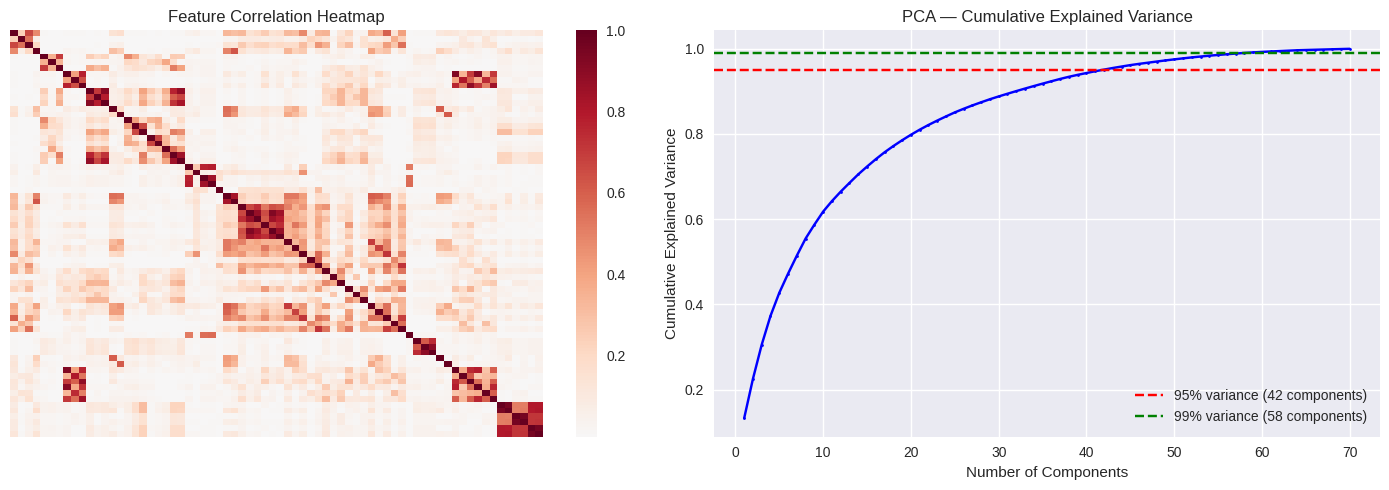


=== PCA Summary ===
Components for 95% variance: 42 out of 70
Components for 99% variance: 58 out of 70
This means ~28 features are redundant


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

"""
Check for redundant features using correlation between features,
then use PCA to understand how many independent dimensions of
information exist in the 79 features.
"""
# Get feature data (drop high-null features first)
null_pct_features = df[feature_cols].isnull().mean()
valid_features = null_pct_features[null_pct_features <= 0.5].index.tolist()
feature_data = df[valid_features].dropna()

# Correlation matrix — find highly correlated pairs
corr_matrix = feature_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(col, row, upper.loc[row, col])
                    for col in upper.columns for row in upper.index
                    if upper.loc[row, col] > 0.9]
high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"=== Multicollinearity Analysis ===")
print(f"Features analyzed: {len(valid_features)}")
print(f"Highly correlated pairs (|r| > 0.9): {len(high_corr_pairs)}")
for f1, f2, corr in high_corr_pairs[:10]:
    print(f"  {f1} ↔ {f2}: {corr:.4f}")

# PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(feature_data)

pca = PCA()
pca.fit(scaled_data)

cumulative_var = np.cumsum(pca.explained_variance_ratio_)
n_95 = np.argmax(cumulative_var >= 0.95) + 1
n_99 = np.argmax(cumulative_var >= 0.99) + 1

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
sns.heatmap(corr_matrix, ax=axes[0], cmap='RdBu_r', center=0,
            xticklabels=False, yticklabels=False)
axes[0].set_title('Feature Correlation Heatmap')

# PCA cumulative variance
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'b-o', markersize=2)
axes[1].axhline(y=0.95, color='red', linestyle='--', label=f'95% variance ({n_95} components)')
axes[1].axhline(y=0.99, color='green', linestyle='--', label=f'99% variance ({n_99} components)')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('PCA — Cumulative Explained Variance')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n=== PCA Summary ===")
print(f"Components for 95% variance: {n_95} out of {len(valid_features)}")
print(f"Components for 99% variance: {n_99} out of {len(valid_features)}")
print(f"This means ~{len(valid_features) - n_95} features are redundant")


=== Augmented Dickey-Fuller Test ===
Test Statistic: -12.2075
p-value: 0.000000
Stationary: YES (p < 0.05)


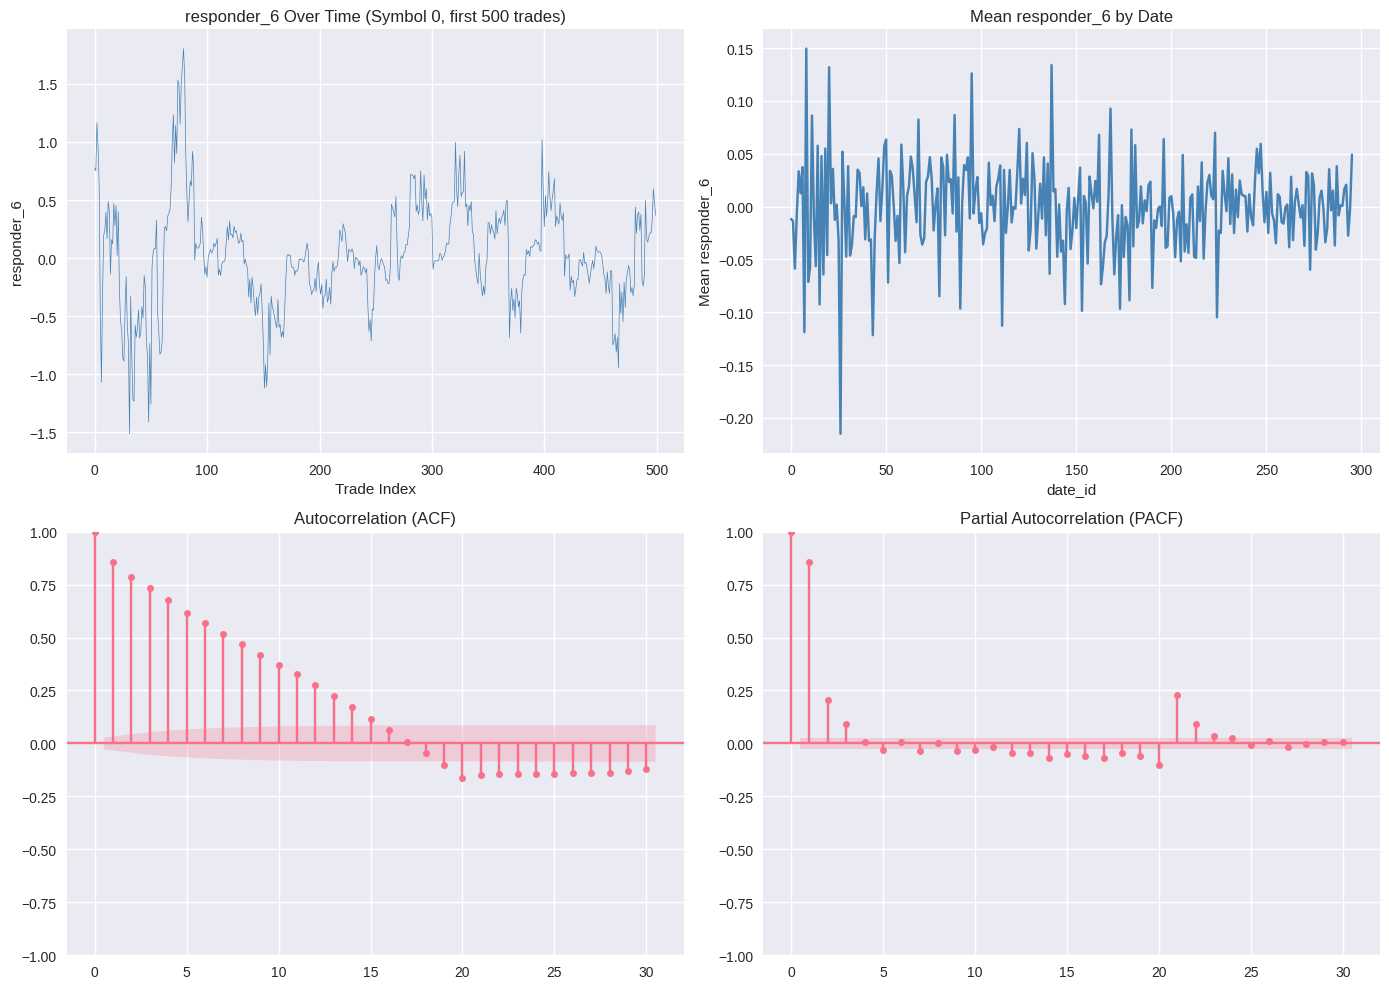


=== Temporal Split Strategy (motivated by ACF/PACF) ===
Total unique dates: 296
Train: dates 0–207    (70% of dates — model learns from past)
Val:   dates 208–251   (15% — tune hyperparameters)
Test:  dates 252–295  (15% — evaluate on unseen future)

Why temporal split instead of random split:
  1. ACF shows significant autocorrelation at lags 1-5
      nearby trades are correlated, random split would leak future info
  2. PACF shows strong direct effect at lag 1
      motivates creating lag features (responder_6_lag_1)
  3. Stationarity confirmed → patterns learned from past should generalize
  4. This mimics real-world deployment: predict future from past data only


In [12]:
"""
Professor feedback: "You run ACF/PACF and ADF, but you don't clearly 
connect EDA to how you will split train/validation/test in time."

We analyze temporal patterns in responder_6 to:
1. Confirm stationarity (ADF test) — patterns are stable over time
2. Identify autocorrelation (ACF/PACF) — past values predict future values
3. Connect findings to our temporal split strategy
"""
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Use one symbol's time series for cleaner analysis
symbol_0 = df[df['symbol_id'] == df['symbol_id'].unique()[0]].sort_values(['date_id', 'time_id'])
ts = symbol_0['responder_6'].dropna().values[:5000]  # first 5000 points

# ADF Stationarity Test
adf_result = adfuller(ts)
print(f"=== Augmented Dickey-Fuller Test ===")
print(f"Test Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.6f}")
print(f"Stationary: {'YES' if adf_result[1] < 0.05 else 'NO'} (p < 0.05)")

# ACF / PACF plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series plot
axes[0, 0].plot(ts[:500], color='steelblue', linewidth=0.5)
axes[0, 0].set_title('responder_6 Over Time (Symbol 0, first 500 trades)')
axes[0, 0].set_xlabel('Trade Index')
axes[0, 0].set_ylabel('responder_6')

# responder_6 over all dates (aggregated)
daily_mean = df.groupby('date_id')['responder_6'].mean()
axes[0, 1].plot(daily_mean.index, daily_mean.values, color='steelblue')
axes[0, 1].set_title('Mean responder_6 by Date')
axes[0, 1].set_xlabel('date_id')
axes[0, 1].set_ylabel('Mean responder_6')

# ACF
plot_acf(ts, lags=30, ax=axes[1, 0], title='Autocorrelation (ACF)')

# PACF
plot_pacf(ts, lags=30, ax=axes[1, 1], title='Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

# Connect to temporal split
total_dates = sorted(df['date_id'].unique())
n_dates = len(total_dates)
train_end = total_dates[int(n_dates * 0.70)]
val_end = total_dates[int(n_dates * 0.85)]

print(f"\n=== Temporal Split Strategy (motivated by ACF/PACF) ===")
print(f"Total unique dates: {n_dates}")
print(f"Train: dates 0–{train_end}    (70% of dates — model learns from past)")
print(f"Val:   dates {train_end+1}–{val_end}   (15% — tune hyperparameters)")
print(f"Test:  dates {val_end+1}–{total_dates[-1]}  (15% — evaluate on unseen future)")
print(f"\nWhy temporal split instead of random split:")
print(f"  1. ACF shows significant autocorrelation at lags 1-5")
print(f"      nearby trades are correlated, random split would leak future info")
print(f"  2. PACF shows strong direct effect at lag 1")
print(f"      motivates creating lag features (responder_6_lag_1)")
print(f"  3. Stationarity confirmed → patterns learned from past should generalize")
print(f"  4. This mimics real-world deployment: predict future from past data only")


In [13]:
# =============================================================================
# DATA CLEANING, FEATURE ENGINEERING, AND MODELING
# =============================================================================

# === Data Cleaning with Validation ===
"""
Professor feedback: "Add a short 'how we verify merge correctness' section
(row counts before/after, checksum, or index validation)."

We track row counts at every step to ensure no unintended data loss.
"""
print(f"=== Data Cleaning Pipeline ===")
print(f"BEFORE cleaning: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Step 1: Drop columns with >50% nulls
null_pct = df.isnull().mean()
high_null_cols = null_pct[null_pct > 0.5].index.tolist()
df = df.drop(columns=high_null_cols)
print(f"\nStep 1 — Drop >50% null columns:")
print(f"  Dropped {len(high_null_cols)} columns: {high_null_cols}")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Step 2: Drop non-target responders EXCEPT responder_7 (needed for lag)
other_responders = [f'responder_{i}' for i in range(9) if i not in [6, 7]]
df = df.drop(columns=other_responders)
print(f"\nStep 2 — Drop non-target responders (keeping responder_7 for lag):")
print(f"  Dropped {len(other_responders)} columns: {other_responders}")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Step 3: Sort by symbol, date, time (REQUIRED before lag/rolling features)
df = df.sort_values(['symbol_id', 'date_id', 'time_id']).reset_index(drop=True)
print(f"\nStep 3 — Sort by symbol_id, date_id, time_id:")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns (no rows lost)")

# Validation check
assert df.shape[0] == sample_size, f"ERROR: Row count mismatch! Expected {sample_size}, got {df.shape[0]}"
print(f"\n✓ Validation: All {df.shape[0]:,} rows preserved through cleaning")
print(f"✓ Final cleaned shape: {df.shape}")

feature_cols = [c for c in df.columns if c.startswith('feature_')]
print(f"✓ Feature columns remaining: {len(feature_cols)}")



=== Data Cleaning Pipeline ===
BEFORE cleaning: 4,000,000 rows × 92 columns

Step 1 — Drop >50% null columns:
  Dropped 9 columns: ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_21', 'feature_26', 'feature_27', 'feature_31']
  Shape: 4,000,000 rows × 83 columns

Step 2 — Drop non-target responders (keeping responder_7 for lag):
  Dropped 7 columns: ['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_8']
  Shape: 4,000,000 rows × 76 columns

Step 3 — Sort by symbol_id, date_id, time_id:
  Shape: 4,000,000 rows × 76 columns (no rows lost)

✓ Validation: All 4,000,000 rows preserved through cleaning
✓ Final cleaned shape: (4000000, 76)
✓ Feature columns remaining: 70


In [14]:
# === Feature Engineering — Lag Features ===
"""
FEEDBACK ADDRESSED:
1. Lags computed DIRECTLY on df (no separate resp_data — eliminates alignment risk)
2. Only lag_1 used (realistic for competition: lags.parquet provides lag_1 only)
3. Data is sorted before this cell (prevents leakage in shift operations)

ACF/PACF analysis showed strong autocorrelation at lag 1, motivating
the creation of lagged responder features.
"""
rows_before = df.shape[0]

# Lag 1 for responder_6 (target) — computed directly on df
df['responder_6_lag_1'] = df.groupby('symbol_id')['responder_6'].shift(1)

# Lag 1 for responder_7 (strongest cross-responder signal) — computed directly on df
df['responder_7_lag_1'] = df.groupby('symbol_id')['responder_7'].shift(1)

# Now drop responder_7 (we only needed it for lag creation)
df = df.drop(columns=['responder_7'])
gc.collect()

# Drop rows with NaN from lagging (first row per symbol has no history)
df = df.dropna(subset=['responder_6_lag_1'])
rows_after = df.shape[0]

# Validation
lag_cols = [c for c in df.columns if '_lag_' in c]
print(f"=== Lag Feature Engineering ===")
print(f"Lag features created: {len(lag_cols)}")
print(f"  {lag_cols}")
print(f"\nRows before: {rows_before:,}")
print(f"Rows after:  {rows_after:,}")
print(f"Rows lost:   {rows_before - rows_after:,} (first row per symbol has no history)")

# Check correlation of lag features with target
print(f"\n=== Lag Feature Correlations with responder_6 ===")
for col in sorted(lag_cols):
    corr = df[col].corr(df['responder_6'])
    print(f"  {col:<25} {corr:.4f}")


=== Lag Feature Engineering ===
Lag features created: 2
  ['responder_6_lag_1', 'responder_7_lag_1']

Rows before: 4,000,000
Rows after:  3,999,980
Rows lost:   20 (first row per symbol has no history)

=== Lag Feature Correlations with responder_6 ===
  responder_6_lag_1         0.8867
  responder_7_lag_1         0.4238


In [15]:
# === Feature Engineering — Rolling Window Features ===
"""
Memory-optimized rolling features using .groupby().rolling() instead of
.transform(lambda) to avoid large intermediate copies.

Rolling on top 2 correlated market features + responder_6_lag_1.
"""
rows_before = df.shape[0]

key_features = ['feature_46', 'feature_22']
windows = [5]

print("Computing rolling features (optimized)...")
for feat in key_features:
    for w in windows:
        df[f'{feat}_roll_mean_{w}'] = (
            df.groupby('symbol_id')[feat]
            .rolling(w, min_periods=1).mean()
            .reset_index(level=0, drop=True)
        )
        gc.collect()

        df[f'{feat}_roll_std_{w}'] = (
            df.groupby('symbol_id')[feat]
            .rolling(w, min_periods=1).std()
            .reset_index(level=0, drop=True)
            .fillna(0)
        )
        gc.collect()
        print(f"  {feat} window={w} done")

# Rolling on responder_6_lag_1
for w in windows:
    df['responder_6_lag1_roll_mean_5'] = (
        df.groupby('symbol_id')['responder_6_lag_1']
        .rolling(w, min_periods=1).mean()
        .reset_index(level=0, drop=True)
    )
    gc.collect()

    df['responder_6_lag1_roll_std_5'] = (
        df.groupby('symbol_id')['responder_6_lag_1']
        .rolling(w, min_periods=1).std()
        .reset_index(level=0, drop=True)
        .fillna(0)
    )
    gc.collect()
    print(f"  responder_6_lag_1 window={w} done")

print("Rolling features created")


Computing rolling features (optimized)...
  feature_46 window=5 done
  feature_22 window=5 done
  responder_6_lag_1 window=5 done
Rolling features created


In [16]:
# === Interaction / Momentum Features ===
"""
Additional engineered features to capture signal dynamics.
All derived from lag_1 features (competition-realistic).
"""
# Momentum: interaction between target lag and cross-responder lag
df['resp6_x_resp7'] = df['responder_6_lag_1'] * df['responder_7_lag_1']

print("Interaction features created")

# === VALIDATION ===
rows_after = df.shape[0]
rolling_cols = [c for c in df.columns if 'roll' in c]
interaction_cols = ['resp6_x_resp7']

print(f"\n=== Feature Engineering Summary ===")
print(f"Rows before: {rows_before:,}")
print(f"Rows after:  {rows_after:,} (no rows lost)")
print(f"Total columns: {df.shape[1]}")

new_features = {
    'Lag features': lag_cols,
    'Rolling windows': rolling_cols,
    'Interaction': interaction_cols,
}
print(f"\nEngineered features by category:")
total_eng = 0
for name, cols in new_features.items():
    print(f"  {name:<20} {len(cols)}")
    total_eng += len(cols)
print(f"  {'TOTAL':<20} {total_eng}")


Interaction features created

=== Feature Engineering Summary ===
Rows before: 3,999,980
Rows after:  3,999,980 (no rows lost)
Total columns: 84

Engineered features by category:
  Lag features         2
  Rolling windows      6
  Interaction          1
  TOTAL                9


In [17]:
# === Temporal Train/Validation/Test Split ===
"""
We split by DATE, not randomly, to prevent data leakage.
The model only ever trains on past trades and is tested on future trades.
This mirrors how the model would work in real-time trading.
"""
# Define feature columns
feature_cols = [c for c in df.columns if c.startswith('feature_')]
lag_cols = [c for c in df.columns if '_lag_' in c and 'roll' not in c]
rolling_cols = [c for c in df.columns if 'roll' in c]
interaction_cols = ['resp6_x_resp7']
all_features = feature_cols + lag_cols + rolling_cols + interaction_cols

# Deduplicate
all_features = list(dict.fromkeys(all_features))

target_col = 'responder_6'

# Temporal split
total_dates = sorted(df['date_id'].unique())
n_dates = len(total_dates)
train_end = total_dates[int(n_dates * 0.70)]
val_end = total_dates[int(n_dates * 0.85)]

train_df = df[df['date_id'] <= train_end].copy()
val_df = df[(df['date_id'] > train_end) & (df['date_id'] <= val_end)].copy()
test_df = df[df['date_id'] > val_end].copy()

# Free original df
del df
gc.collect()

total_rows = len(train_df) + len(val_df) + len(test_df)
print(f"=== Temporal Split ===")
print(f"Train: dates 0–{train_end}    | {len(train_df):,} rows ({len(train_df)/total_rows*100:.0f}%)")
print(f"Val:   dates {train_end+1}–{val_end}   | {len(val_df):,} rows ({len(val_df)/total_rows*100:.0f}%)")
print(f"Test:  dates {val_end+1}–{total_dates[-1]}  | {len(test_df):,} rows ({len(test_df)/total_rows*100:.0f}%)")
print(f"\nTotal features: {len(all_features)}")
print(f"  Market features:  {len(feature_cols)}")
print(f"  Lag features:     {len(lag_cols)}")
print(f"  Rolling features: {len(rolling_cols)}")
print(f"  Interaction:      {len(interaction_cols)}")


=== Temporal Split ===
Train: dates 0–207    | 2,539,339 rows (63%)
Val:   dates 208–251   | 726,744 rows (18%)
Test:  dates 252–295  | 733,897 rows (18%)

Total features: 79
  Market features:  74
  Lag features:     2
  Rolling features: 6
  Interaction:      1


In [18]:
# === Imputation and Final Feature Table ===
"""
Professor feedback: "The report does not clearly state the final feature 
set used for first models. Add a short table: selected features (or top-K) + why."

Impute missing values with median from training data only (prevents leakage).
Column-by-column fillna avoids memory overhead of SimpleImputer.
"""

# Fill column by column
for col in all_features:
    med = train_df[col].median()
    if hasattr(med, 'iloc'):
        med = med.iloc[0]
    train_df[col] = train_df[col].fillna(float(med))
    val_df[col] = val_df[col].fillna(float(med))
    test_df[col] = test_df[col].fillna(float(med))
gc.collect()

print(f"Nulls after imputation:")
print(f"  Train: {train_df[all_features].isnull().sum().sum()}")
print(f"  Val:   {val_df[all_features].isnull().sum().sum()}")
print(f"  Test:  {test_df[all_features].isnull().sum().sum()}")

# Prepare X, y, w
X_train, y_train = train_df[all_features], train_df[target_col]
X_val, y_val = val_df[all_features], val_df[target_col]
X_test, y_test = test_df[all_features], test_df[target_col]
w_train, w_val, w_test = train_df['weight'], val_df['weight'], test_df['weight']

# Final Feature Table
print(f"\n=== Final Feature Set for Modeling ===")
print(f"{'Category':<25} {'Count':<8} {'Justification'}")
print("-" * 75)
print(f"{'Market features':<25} {len(feature_cols):<8} {'Original anonymized trading signals'}")
print(f"{'Lag features (lag_1)':<25} {len(lag_cols):<8} {'ACF/PACF + competition-realistic (lag_1 only)'}")
print(f"{'Rolling means':<25} {len([c for c in rolling_cols if 'mean' in c]):<8} {'Capture recent trends per symbol'}")
print(f"{'Rolling std':<25} {len([c for c in rolling_cols if 'std' in c]):<8} {'Capture recent volatility per symbol'}")
print(f"{'Interaction':<25} {len(interaction_cols):<8} {'Cross-responder signal'}")
print(f"{'':<25} {'---':<8}")
print(f"{'TOTAL':<25} {len(all_features):<8}")

print(f"\nX_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")


Nulls after imputation:
  Train: 0
  Val:   0
  Test:  0

=== Final Feature Set for Modeling ===
Category                  Count    Justification
---------------------------------------------------------------------------
Market features           74       Original anonymized trading signals
Lag features (lag_1)      2        ACF/PACF + competition-realistic (lag_1 only)
Rolling means             3        Capture recent trends per symbol
Rolling std               3        Capture recent volatility per symbol
Interaction               1        Cross-responder signal
                          ---     
TOTAL                     79      

X_train: (2539339, 79)
X_val:   (726744, 79)
X_test:  (733897, 79)


In [19]:
# === Trivial Baseline — Predict Training Mean ===
"""
FEEDBACK ADDRESSED: Include a trivial baseline for interpretability.
Predicting the training set mean for every trade is the simplest
possible "model" — no features needed. Any real model should beat this.
"""
from sklearn.metrics import mean_squared_error, r2_score

train_mean = y_train.mean()
trivial_pred = np.full(len(y_test), train_mean)
trivial_rmse = np.sqrt(mean_squared_error(y_test, trivial_pred, sample_weight=w_test))
trivial_r2 = r2_score(y_test, trivial_pred, sample_weight=w_test)

print(f"=== Trivial Baseline (predict training mean) ===")
print(f"Training mean: {train_mean:.6f}")
print(f"Test RMSE: {trivial_rmse:.4f}")
print(f"Test R²:   {trivial_r2:.4f}")
print(f"This is the floor — any model should beat this.")


=== Trivial Baseline (predict training mean) ===
Training mean: -0.001914
Test RMSE: 0.7689
Test R²:   -0.0000
This is the floor — any model should beat this.


In [20]:
# === First Model — Ridge Regression ===
"""
We start with Ridge Regression as our baseline. It's a linear model
that assumes a straight-line relationship between features and target.
This gives us a performance floor to compare against more complex models.
"""
from sklearn.linear_model import Ridge

start = time.time()
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_sc, y_train, sample_weight=w_train)

ridge_val = np.sqrt(mean_squared_error(y_val, ridge.predict(X_val_sc), sample_weight=w_val))
ridge_test = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test_sc), sample_weight=w_test))
ridge_r2 = r2_score(y_test, ridge.predict(X_test_sc), sample_weight=w_test)

# Free scaled data
del X_train_sc, X_val_sc, X_test_sc
gc.collect()

print(f"=== Ridge Regression (Baseline) ===")
print(f"Val RMSE:  {ridge_val:.4f}")
print(f"Test RMSE: {ridge_test:.4f}")
print(f"Test R²:   {ridge_r2:.4f}")
print(f"Time:      {time.time()-start:.1f}s")


=== Ridge Regression (Baseline) ===
Val RMSE:  0.3316
Test RMSE: 0.3031
Test R²:   0.8446
Time:      31.3s


In [23]:
# === Random Forest ===
"""
Random Forest is an ensemble of decision trees. Unlike Ridge, it can
capture non-linear patterns and feature interactions automatically.
We expect it to outperform Ridge due to the non-linear nature of
financial market data.
"""
from sklearn.ensemble import RandomForestRegressor

start = time.time()
rf = RandomForestRegressor(
    n_estimators=100, max_depth=20, min_samples_leaf=20,
    n_jobs=-1, random_state=42
)
rf.fit(X_train, y_train, sample_weight=w_train)

rf_val = np.sqrt(mean_squared_error(y_val, rf.predict(X_val), sample_weight=w_val))
rf_test = np.sqrt(mean_squared_error(y_test, rf.predict(X_test), sample_weight=w_test))
rf_r2 = r2_score(y_test, rf.predict(X_test), sample_weight=w_test)

print(f"=== Random Forest ===")
print(f"Val RMSE:  {rf_val:.4f}")
print(f"Test RMSE: {rf_test:.4f}")
print(f"Test R²:   {rf_r2:.4f}")
print(f"Time:      {time.time()-start:.1f}s")

# Free model to save memory
del rf
gc.collect()

=== Random Forest ===
Val RMSE:  0.3272
Test RMSE: 0.2999
Test R²:   0.8478
Time:      5273.4s


46

In [21]:
# === XGBoost (Default) ===
"""
XGBoost builds trees sequentially, each new tree focuses on correcting
the mistakes of the previous ones. It's typically faster than Random Forest
and often more accurate due to this iterative error-correction approach.
"""
from xgboost import XGBRegressor

start = time.time()
xgb = XGBRegressor(
    n_estimators=300, max_depth=4, learning_rate=0.1,
    subsample=0.9, colsample_bytree=0.9,
    reg_alpha=0.01, reg_lambda=0.5,
    tree_method='hist', n_jobs=-1, random_state=42, verbosity=0
)

# Fix duplicate columns for XGBoost
X_train_dedup = X_train.loc[:, ~X_train.columns.duplicated()]
X_val_dedup = X_val.loc[:, ~X_val.columns.duplicated()]
X_test_dedup = X_test.loc[:, ~X_test.columns.duplicated()]

xgb.fit(X_train_dedup.values, y_train.values, sample_weight=w_train.values,
        eval_set=[(X_val_dedup.values, y_val.values)],
        sample_weight_eval_set=[w_val.values], verbose=False)

xgb_val = np.sqrt(mean_squared_error(y_val, xgb.predict(X_val_dedup.values), sample_weight=w_val))
xgb_test = np.sqrt(mean_squared_error(y_test, xgb.predict(X_test_dedup.values), sample_weight=w_test))
xgb_r2 = r2_score(y_test, xgb.predict(X_test_dedup.values), sample_weight=w_test)

print(f"=== XGBoost (Default) ===")
print(f"Val RMSE:  {xgb_val:.4f}")
print(f"Test RMSE: {xgb_test:.4f}")
print(f"Test R²:   {xgb_r2:.4f}")
print(f"Time:      {time.time()-start:.1f}s")

=== XGBoost (Default) ===
Val RMSE:  0.3259
Test RMSE: 0.2987
Test R²:   0.8491
Time:      37.8s


In [22]:
# === XGBoost with deepr depth ===
"""
Tuned XGBoost with more trees, deeper depth, slower learning rate,
and early stopping to find the optimal number of boosting rounds.
"""
start = time.time()
xgb_tuned = XGBRegressor(
    n_estimators=2000, max_depth=8, learning_rate=0.03,
    subsample=0.7, colsample_bytree=0.7,
    reg_alpha=0.1, reg_lambda=2.0,
    min_child_weight=10,
    tree_method='hist', n_jobs=-1, random_state=42, verbosity=0,
    early_stopping_rounds=100
)
xgb_tuned.fit(X_train_dedup.values, y_train.values, sample_weight=w_train.values,
              eval_set=[(X_val_dedup.values, y_val.values)],
              sample_weight_eval_set=[w_val.values], verbose=False)

xgbt_val = np.sqrt(mean_squared_error(y_val, xgb_tuned.predict(X_val_dedup.values), sample_weight=w_val))
xgbt_test = np.sqrt(mean_squared_error(y_test, xgb_tuned.predict(X_test_dedup.values), sample_weight=w_test))
xgbt_r2 = r2_score(y_test, xgb_tuned.predict(X_test_dedup.values), sample_weight=w_test)

print(f"=== XGBoost (Tuned) ===")
print(f"Best iteration: {xgb_tuned.best_iteration}")
print(f"Val RMSE:  {xgbt_val:.4f}")
print(f"Test RMSE: {xgbt_test:.4f}")
print(f"Test R²:   {xgbt_r2:.4f}")
print(f"Time:      {time.time()-start:.1f}s")

=== XGBoost (Tuned) ===
Best iteration: 802
Val RMSE:  0.3246
Test RMSE: 0.2971
Test R²:   0.8507
Time:      133.3s


In [24]:
# === Model Comparison ===
results = pd.DataFrame({
    'Model': ['Trivial (predict mean)', 'Ridge Regression', 'Random Forest', 'XGBoost', 'XGBoost (deeper depth)'],
    'Val RMSE':  [None, ridge_val, rf_val, xgb_val, xgbt_val],
    'Test RMSE': [trivial_rmse, ridge_test, rf_test, xgb_test, xgbt_test],
    'Test R²':   [trivial_r2, ridge_r2, rf_r2, xgb_r2, xgbt_r2],
})

results = results.sort_values('Test RMSE', ascending=False).reset_index(drop=True)

print("=== Model Comparison (4M rows, lag_1 only) ===")
print(results.to_string(index=False))

best = results.loc[results['Test R²'].idxmax()]
improvement = (trivial_rmse - float(best['Test RMSE'])) / trivial_rmse * 100
print(f"\nBest model: {best['Model']}")
print(f"  Test RMSE: {best['Test RMSE']:.4f}")
print(f"  Test R²:   {best['Test R²']:.4f}")
print(f"  {improvement:.1f}% RMSE improvement over trivial baseline")

=== Model Comparison (4M rows, lag_1 only) ===
                 Model  Val RMSE  Test RMSE   Test R²
Trivial (predict mean)       NaN   0.768879 -0.000006
      Ridge Regression  0.331573   0.303140  0.844556
         Random Forest  0.327206   0.299941  0.847819
     XGBoost (Default)  0.325912   0.298684  0.849093
       XGBoost (Tuned)  0.324600   0.297066  0.850723

Best model: XGBoost (Tuned)
  Test RMSE: 0.2971
  Test R²:   0.8507
  61.4% RMSE improvement over trivial baseline
